In [9]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
from random import sample, randint
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import os
import glob
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense

from scipy.signal import savgol_filter

cwd = os.getcwd()
if cwd == "/content":
    from google.colab import drive
print("cwd is :", cwd)
def printdocs(pname):
    exec("print("+str(pname)+".__doc__)")

if cwd == "/content":
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive/data/RLA3_data
    %cd /content/drive/MyDrive/data/RLA3_data
    from Helper import argmax, softmax
else:
    print("cwd is :", cwd)

print("argmax docs :", argmax.__doc__)
print("softmax docs :", softmax.__doc__)

In [ ]:
# if no helper available, use this cell

# def softmax(x, temp):
#     ''' Computes the softmax of vector x with temperature parameter 'temp' '''
#     x = x / temp # scale by temperature
#     z = x - max(x) # substract max to prevent overflow of softmax 
#     return np.exp(z)/np.sum(np.exp(z)) # compute softmax

# def argmax(x):
#     ''' Own variant of np.argmax with random tie breaking '''
#     try:
#         return np.random.choice(np.where(x == np.max(x))[0])
#     except:
#         return np.argmax(x)


In [2]:
class policy_network(keras.Model):
    def __init__(self, n_states, n_actions, ):
        super().__init__()
        self.n_actions = n_actions
        self.ip = keras.layers.Flatten(input_shape = n_states)
        self.l1 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.l2 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.l3 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.op = keras.layers.Dense(n_actions, activation="softmax")
#     def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
#         super(policy_network, self).__init__()
#         self.fc1_dims = fc1_dims
#         self.fc2_dims = fc2_dims
#         self.n_actions = n_actions

#         self.fc1 = Dense(self.fc1_dims, activation='relu')
#         self.fc2 = Dense(self.fc2_dims, activation='relu')
#         self.pi = Dense(n_actions, activation='softmax')

    def call(self, state, ):
        fp = self.ip(state)
        fp = self.l1(fp)
        fp = self.l2(fp)
        fp = self.l3(fp)
        policy = self.op(fp)
        return policy

#     def call(self, state):
#         value = self.fc1(state)
#         value = self.fc2(value)

#         pi = self.pi(value)

#         return pi

In [3]:
class agent():
    def __init__(self, n_actions, n_states, lr = 0.003, gamma = 0.99,  ):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        print("action space shape : {}".format(self.n_actions))
        print("state space shape : {}".format(self.n_states))
        self.states = []
        self.actions = []
        self.rewards = []
        self.pi = policy_network(n_states = self.n_states, n_actions = n_actions)                    # check
#         self.pi = policy_network(n_actions = n_actions)
        self.pi.compile(optimizer = keras.optimizers.Adam(learning_rate = self.lr))                  # check

    def get_act(self, state, ):
        '''takes a state and returns a tensor of action categorical probabilities'''
        state_t = tf.convert_to_tensor([state], dtype = tf.float32)
        probs = self.pi(state_t)
        cat_probs = tfp.distributions.Categorical(probs = probs)
        action = cat_probs.sample()
#         print(action.numpy()[0])
        
        return action.numpy()[0]
    
#         state = tf.convert_to_tensor([observation], dtype=tf.float32)
#         probs = self.policy(state)
#         action_probs = tfp.distributions.Categorical(probs=probs)
#         action = action_probs.sample()
#         print(action.numpy()[0])
#         return action.numpy()

    def remember(self, state, action, reward, ):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def learn(self):
        actions_t = tf.convert_to_tensor(self.actions, dtype = tf.float32)
        rewards_arr = np.array(self.rewards)

        returns = np.zeros_like(rewards_arr)
        for state_id in range(returns.shape[-1]):
            returns_ds = 0
            discount_factor = 1
            for state_id_ds in range(state_id, returns.shape[-1]):
                returns_ds += rewards_arr[state_id_ds]*discount_factor
                discount_factor *= self.gamma
                
            returns[state_id] = returns_ds

        with tf.GradientTape() as tape:
            loss = 0
            for state_id, (return_g, state_g) in enumerate(zip(returns, self.states)):
                state_g = tf.convert_to_tensor([state_g], dtype = tf.float32)
                probabilities = self.pi(state_g)
                action_probabilities = tfp.distributions.Categorical(probs = probabilities)
                log_probabilities = action_probabilities.log_prob(actions_t[state_id])
                loss += -return_g * tf.squeeze(log_probabilities)

        grad = tape.gradient(loss, self.pi.trainable_variables)
        self.pi.optimizer.apply_gradients(zip(grad, self.pi.trainable_variables))

        self.states = []
        self.actions = []
        self.rewards = []


In [4]:
# import your agent
learnrate = 0.001
gam = 0.99
runs = 8
ep_num = 100

for run_num in runs:
    if __name__ == "__main__":

        # initialise environment
        env = gym.make('CartPole-v1')

        # initialize agent
        agent_007 = agent(lr = learnrate, gamma = gam, n_actions = env.action_space.n, n_states = env.observation_space.shape)

        
        score_hist = []

        # episode loop
        for i in range(ep_num):
            done = False
            score = 0
            s = env.reset()

            # step loop
            while not done:
                a = agent_007.get_act(s)
                s_next,reward,done,_ = env.step(a)
                agent_007.remember(s,a,reward)
                s = s_next
                score += reward
    #             env.render()
            score_hist.append(score)

            # make agent learn
            agent_007.learn()
            avg_score = np.mean(score_hist[-100:])
            print('episode: ', i,'score: %.1f' % score,
                'average score %.1f' % avg_score)
        
#         print()
        
    # plot


action space shape : 2
state space shape : (4,)
episode:  0 score: 16.0 average score 16.0
episode:  1 score: 15.0 average score 15.5
episode:  2 score: 23.0 average score 18.0
episode:  3 score: 18.0 average score 18.0
episode:  4 score: 41.0 average score 22.6
episode:  5 score: 24.0 average score 22.8
episode:  6 score: 28.0 average score 23.6
episode:  7 score: 22.0 average score 23.4
episode:  8 score: 20.0 average score 23.0
episode:  9 score: 24.0 average score 23.1
episode:  10 score: 18.0 average score 22.6
episode:  11 score: 49.0 average score 24.8
episode:  12 score: 51.0 average score 26.8
episode:  13 score: 48.0 average score 28.4
episode:  14 score: 21.0 average score 27.9
episode:  15 score: 24.0 average score 27.6
episode:  16 score: 29.0 average score 27.7
episode:  17 score: 35.0 average score 28.1
episode:  18 score: 33.0 average score 28.4
episode:  19 score: 14.0 average score 27.6
episode:  20 score: 27.0 average score 27.6
episode:  21 score: 37.0 average score

episode:  182 score: 133.0 average score 130.0
episode:  183 score: 176.0 average score 131.1
episode:  184 score: 291.0 average score 133.0
episode:  185 score: 125.0 average score 133.6
episode:  186 score: 197.0 average score 135.0
episode:  187 score: 147.0 average score 135.9
episode:  188 score: 274.0 average score 138.3
episode:  189 score: 186.0 average score 139.6
episode:  190 score: 203.0 average score 139.7
episode:  191 score: 218.0 average score 140.6
episode:  192 score: 188.0 average score 142.1
episode:  193 score: 267.0 average score 144.3
episode:  194 score: 319.0 average score 146.8
episode:  195 score: 347.0 average score 149.9
episode:  196 score: 199.0 average score 151.2
episode:  197 score: 239.0 average score 152.4
episode:  198 score: 290.0 average score 154.6
episode:  199 score: 255.0 average score 156.7
episode:  200 score: 269.0 average score 158.9
episode:  201 score: 242.0 average score 160.9
episode:  202 score: 235.0 average score 162.5
episode:  203

episode:  358 score: 218.0 average score 122.0
episode:  359 score: 155.0 average score 122.9
episode:  360 score: 183.0 average score 124.1
episode:  361 score: 244.0 average score 125.5
episode:  362 score: 225.0 average score 127.3
episode:  363 score: 210.0 average score 128.5
episode:  364 score: 255.0 average score 130.2
episode:  365 score: 265.0 average score 132.4
episode:  366 score: 180.0 average score 132.9
episode:  367 score: 201.0 average score 134.5
episode:  368 score: 133.0 average score 135.3
episode:  369 score: 173.0 average score 136.5
episode:  370 score: 240.0 average score 138.3
episode:  371 score: 153.0 average score 139.0
episode:  372 score: 177.0 average score 140.3
episode:  373 score: 149.0 average score 140.8
episode:  374 score: 148.0 average score 141.7
episode:  375 score: 187.0 average score 142.6
episode:  376 score: 186.0 average score 143.7
episode:  377 score: 194.0 average score 144.5
episode:  378 score: 230.0 average score 146.1
episode:  379

episode:  533 score: 161.0 average score 265.2
episode:  534 score: 194.0 average score 265.8
episode:  535 score: 196.0 average score 265.7
episode:  536 score: 234.0 average score 265.9
episode:  537 score: 133.0 average score 265.5
episode:  538 score: 200.0 average score 266.0
episode:  539 score: 223.0 average score 266.4
episode:  540 score: 232.0 average score 267.0
episode:  541 score: 179.0 average score 266.3
episode:  542 score: 202.0 average score 266.6
episode:  543 score: 155.0 average score 265.6
episode:  544 score: 315.0 average score 265.7
episode:  545 score: 164.0 average score 264.4
episode:  546 score: 247.0 average score 264.8
episode:  547 score: 199.0 average score 264.5
episode:  548 score: 172.0 average score 264.7
episode:  549 score: 191.0 average score 263.0
episode:  550 score: 314.0 average score 263.6
episode:  551 score: 305.0 average score 264.4
episode:  552 score: 245.0 average score 264.5
episode:  553 score: 197.0 average score 262.8
episode:  554

episode:  708 score: 500.0 average score 432.2
episode:  709 score: 298.0 average score 430.2
episode:  710 score: 500.0 average score 430.2
episode:  711 score: 436.0 average score 429.6
episode:  712 score: 500.0 average score 429.6
episode:  713 score: 500.0 average score 429.6
episode:  714 score: 500.0 average score 431.1
episode:  715 score: 500.0 average score 433.1
episode:  716 score: 390.0 average score 434.3
episode:  717 score: 500.0 average score 435.4
episode:  718 score: 344.0 average score 435.6
episode:  719 score: 500.0 average score 437.2
episode:  720 score: 500.0 average score 437.2
episode:  721 score: 500.0 average score 437.8
episode:  722 score: 500.0 average score 439.9
episode:  723 score: 399.0 average score 440.9
episode:  724 score: 500.0 average score 443.1
episode:  725 score: 500.0 average score 443.8
episode:  726 score: 500.0 average score 444.9
episode:  727 score: 500.0 average score 444.9
episode:  728 score: 500.0 average score 446.5
episode:  729

episode:  883 score: 500.0 average score 467.6
episode:  884 score: 500.0 average score 467.6
episode:  885 score: 500.0 average score 467.6
episode:  886 score: 500.0 average score 467.6
episode:  887 score: 500.0 average score 467.6
episode:  888 score: 500.0 average score 467.6
episode:  889 score: 500.0 average score 467.6
episode:  890 score: 500.0 average score 467.6
episode:  891 score: 500.0 average score 467.6
episode:  892 score: 500.0 average score 470.8
episode:  893 score: 500.0 average score 470.8
episode:  894 score: 500.0 average score 470.8
episode:  895 score: 500.0 average score 470.8
episode:  896 score: 500.0 average score 470.8
episode:  897 score: 500.0 average score 471.7
episode:  898 score: 500.0 average score 471.7
episode:  899 score: 500.0 average score 471.7
episode:  900 score: 500.0 average score 471.7
episode:  901 score: 500.0 average score 471.7
episode:  902 score: 500.0 average score 473.4
episode:  903 score: 500.0 average score 473.4
episode:  904

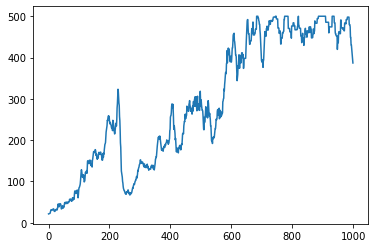

In [11]:
avg_score_hist = smooth(score_hist,11)
plt.plot(avg_score_hist)

In [7]:
'''
convenience functions
'''

def smooth(y, window, poly=1):
    '''
    y: vector to be smoothed 
    window: size of the smoothing window '''
    return savgol_filter(y,window,poly)

def single_plot(data,title = "title",xsize = 7, ysize = 7,xaxis = "xaxis", yaxis = "yaxis", yscale = "linear"):
    '''
    single_plot(data,title = "title",xsize = 7, ysize = 7,xaxis = "xaxis", yaxis = "yaxis", yscale = "linear"):
    plot a figure with a single subplot using 'data' data and 'title' of size (xsize X ysize)
    '''
    fig,axs = plt.subplots(1,1,figsize = (xsize,ysize))
    # axs.imshow(im[frame_num],norm = mpl.colors.LogNorm())
    axs.plot(data)
    axs.set_xlabel(xaxis)
    axs.set_ylabel(yaxis)
    axs.set_yscale(yscale)
    axs.set_title(title)
    return axs

def better_safe(fname = "reinforce_v1_lr_"+str(learnrate)+".csv"):
    try:
        fig = plt.figure(figsize = (14,7))
        list_y = []
        for i,y in enumerate(cum_rewards):
            y = np.array(y)
            y = np.pad(y,(0,300-y.shape[0]),mode = 'constant',constant_values = (np.nan))
            list_y.append(y)
            np.savetxt(fname, list_y, delimiter = "," )
    #         print(y.shape)
            plt.plot(range(y.shape[0]),y,label = r"run "+str(i+1))
        plt.title("TN individual")
        plt.xlabel("Rewards")
        plt.ylabel("Episodes")
        list_y = np.array(list_y)
        print(list_y.shape)
        fig = plt.figure(figsize = (14,7))
        plt.plot(range(300), np.nanmean(list_y, axis = 0))
        plt.xlabel("Rewards")
        plt.ylabel("Episodes")
        plt.title("TN individual")
    except Exception as e:
        print(e)

NameError: name 'learnrate' is not defined